In [1]:
pip install xgboost lightgbm catboost optuna

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 MB 11.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 125.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 30.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 kB 57.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 23.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [46]:
import boto3
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns

from scipy.stats import rankdata
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, StratifiedKFold, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, roc_auc_score, cohen_kappa_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import optuna as op

s3 = boto3.resource('s3')
bucket_name = 'analytics-data-science-competitions'
bucket = s3.Bucket(bucket_name)

file_key_1 = 'Tabular-Playground-Series/TS-S3-Ep5/train.csv'
file_key_2 = 'Tabular-Playground-Series/TS-S3-Ep5/test.csv'
file_key_3 = 'Tabular-Playground-Series/TS-S3-Ep5/sample_submission.csv'

bucket_object_1 = bucket.Object(file_key_1)
file_object_1 = bucket_object_1.get()
file_content_stream_1 = file_object_1.get('Body')

bucket_object_2 = bucket.Object(file_key_2)
file_object_2 = bucket_object_2.get()
file_content_stream_2 = file_object_2.get('Body')

bucket_object_3 = bucket.Object(file_key_3)
file_object_3 = bucket_object_3.get()
file_content_stream_3 = file_object_3.get('Body')

## Reading data files
train = pd.read_csv(file_content_stream_1)
test = pd.read_csv(file_content_stream_2)
submission = pd.read_csv(file_content_stream_3)

# Feature Engineering

In [47]:
# train['total_acid'] = train['fixed acidity'] + train['volatile acidity'] + train['citric acid']
# train['acid/density'] = train['total_acid']  / train['density']
train['alcohol_density'] = train['alcohol']  * train['density']
train['sulphate/density'] = train['sulphates']  / train['density']
# train['sulphates/acid'] = train['sulphates'] / train['volatile acidity']
# train['sulphates/chlorides'] = train['sulphates'] / train['chlorides']
# train['sulphates*alcohol'] = train['sulphates'] / train['alcohol']


# test['total_acid'] = test['fixed acidity'] + test['volatile acidity'] + test['citric acid']
# test['acid/density'] = test['total_acid']  / test['density']
test['alcohol_density'] = test['alcohol']  * test['density']
test['sulphate/density'] = test['sulphates']  / test['density']
# test['sulphates/acid'] = test['sulphates'] / test['volatile acidity']
# test['sulphates/chlorides'] = test['sulphates'] / test['chlorides']
# test['sulphates*alcohol'] = test['sulphates'] / test['alcohol']

# XGBoost 

In [48]:
test_md = test.copy()

X = train.drop(columns = ['Id', 'quality'], axis = 1)
Y = train['quality'] - 3
test_md = test_md.drop(columns = 'Id', axis = 1)

XGB_cv_scores, XGB_imp = list(), list()
preds = list()

## Running 5 times CV
for i in range(5):
    
    skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)
    
    for train_ix, test_ix in skf.split(X, Y):
        
        ## Splitting the data 
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
                
        ## Building RF model
        XGB_md = XGBClassifier(tree_method = 'hist',
                               colsample_bytree = 0.75, 
                               gamma = 0.8, 
                               learning_rate = 0.01, 
                               max_depth = 5, 
                               min_child_weight = 10, 
                               n_estimators = 1000, 
                               subsample = 0.7).fit(X_train, Y_train)
        XGB_imp.append(XGB_md.feature_importances_)
        
        ## Predicting on X_test and test
        XGB_pred_1 = XGB_md.predict(X_test)
        XGB_pred_2 = XGB_md.predict(test_md)
        
        ## Computing roc-auc score
        XGB_cv_scores.append(cohen_kappa_score(Y_test, XGB_pred_1, weights = 'quadratic'))
        preds.append(XGB_pred_2)

XGB_cv_score = np.mean(XGB_cv_scores)    
print('The average roc-auc score over 5-folds (run 5 times) is:', XGB_cv_score)

The average roc-auc score over 5-folds (run 5 times) is: 0.5022545527932221


In [49]:
XGB_preds_test = pd.DataFrame(preds).mode(axis = 0).loc[0, ] + 3

submission['quality'] = XGB_preds_test.astype(int)
submission.head()

,Id,quality
0,2056,6
1,2057,6
2,2058,6
3,2059,6
4,2060,5


In [50]:
submission['quality'].value_counts()

6    635
5    567
7    170
Name: quality, dtype: int64

In [51]:
submission.to_csv('XGB_baseline_FE_2.csv', index = False)

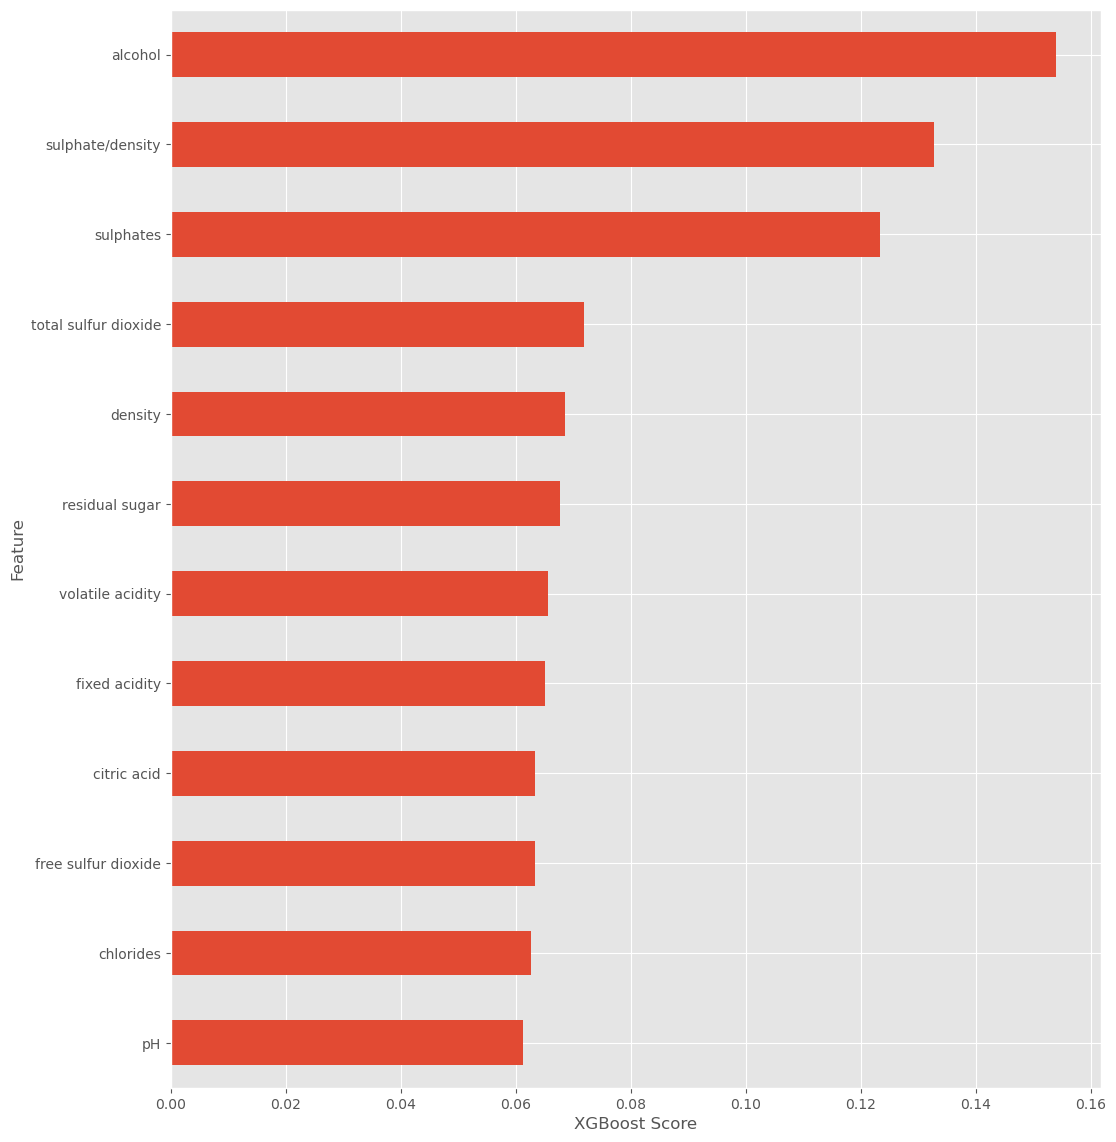

In [45]:
plt.figure(figsize = (12, 14))
pd.DataFrame(XGB_imp, columns = X.columns).apply(np.mean, axis = 0).sort_values().plot(kind = 'barh');
plt.xlabel('XGBoost Score')
plt.ylabel('Feature')
plt.show();